In [3]:
# Imports 
import torch
import torch.nn as nn
import torch.nn.functional as F
import healpy as hp
import numpy as np

In [4]:
# defining required nn modules
class SphericalConv(nn.Module):
    def __init__(self, NSIDE, in_channels, out_channels, bias=True, nest=True):
        """Convolutional layer as defined in Krachmalnicoff & Tomasi (A&A, 2019, 628, A129)
        Parameters
        ----------
        NSIDE : int
            HEALPix NSIDE
        in_channels : int
            Number of channels of the input. The size is [B,C_in,N], with B batches, 
            C_in channels and N pixels in the HEALPix pixelization
        out_channels : int
            Number of channels of the output. The size is [B,C_out,N], with B batches, 
            C_out channels and N pixels in the HEALPix pixelization
        bias : bool, optional
            Add bias, by default True
        nest : bool, optional
            Used nested mapping, by default True
            Always use nested mapping if pooling layers are used.
        """
        super(SphericalConv, self).__init__()
        self.NSIDE = NSIDE
        self.npix = hp.nside2npix(self.NSIDE)
        self.nest = nest
        self.neighbours = torch.zeros(9 * self.npix, dtype=torch.long)
        self.weight = torch.ones(9 * self.npix, dtype=torch.float32)
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=9, stride=9, bias=bias)

        for i in range(self.npix):
            neighbours = hp.pixelfunc.get_all_neighbours(self.NSIDE, i, nest=nest)
            neighbours = np.insert(neighbours, 4, i)
            ind = np.where(neighbours == -1)[0]
            neighbours[ind] = self.npix            
            self.neighbours[9*i:9*i+9] = torch.tensor(neighbours)

        self.zeros = torch.zeros((1, 1, 1))
        nn.init.kaiming_normal_(self.conv.weight)        
        if (bias):
            nn.init.constant_(self.conv.bias, 0.0)
        
    def forward(self, x):
        x2 = F.pad(x, (0,1,0,0,0,0), mode='constant', value=0.0)
        vec = x2[:, :, self.neighbours]
        tmp = self.conv(vec)
        return tmp

class SphericalDown(nn.Module):    
    def __init__(self, NSIDE):
        """Average pooling layer
        Parameters
        ----------
        NSIDE : int
            HEALPix NSIDE
        """
        super(SphericalDown, self).__init__()
        self.pool = nn.AvgPool1d(4) # todo add more than average pooling
        
    def forward(self, x):    
        return self.pool(x)

class SphericalUp(nn.Module):
    def __init__(self, NSIDE):
        """Upsampling pooling layer
        Parameters
        ----------
        NSIDE : int
            HEALPix NSIDE
        """
        super(SphericalUp, self).__init__()
                
    def forward(self, x):
        return torch.repeat_interleave(x, 4, dim=-1) # todo add proper upsampling instead of interleaving
      

In [20]:
# instantiate layers and constants
NSIDE = 32
nest = True

conv = SphericalConv(NSIDE, 1, 1, nest=nest)
down = SphericalDown(NSIDE)
up = SphericalUp(NSIDE // 2)

12288


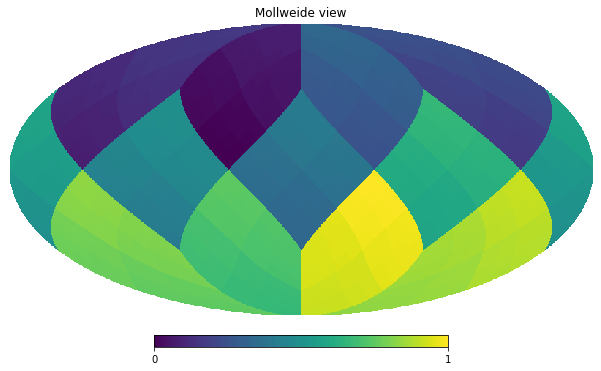

In [21]:
# instantiate empty map (linear interpolation from 0 to 1)
npix = hp.nside2npix(NSIDE)

im = torch.zeros(1,1,npix, requires_grad=False)

im[0, 0, :] = torch.linspace(0.0, 1.0, npix)
hp.mollview(im[0, 0, :].numpy(), nest=nest)
print(npix)

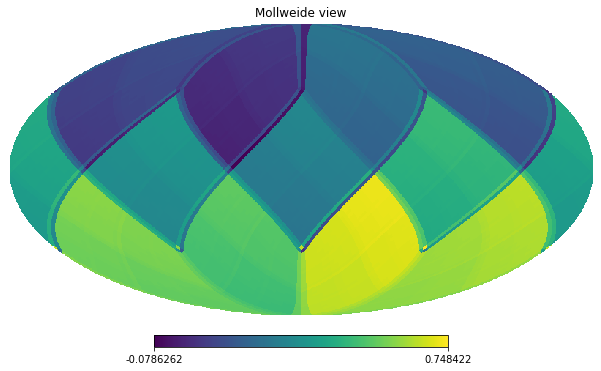

In [22]:
# perform spherical conv on this map
with torch.no_grad():
    out = conv(im)

hp.mollview(out[0, 0, :].numpy(), nest=nest)

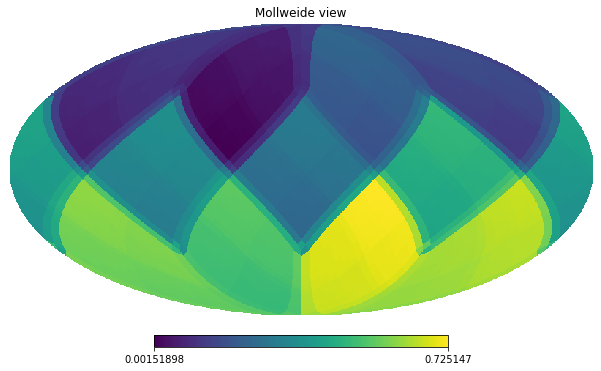

In [23]:
# perform conv + down + upsampling
with torch.no_grad():    
    out = conv(im)
    out = down(out)    
    out = up(out)

hp.mollview(out[0 , 0, :].numpy(), nest=nest)

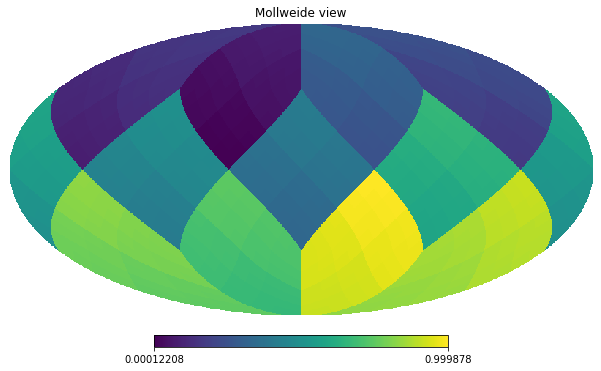

In [24]:
# perform only downsampling
with torch.no_grad():
    out = down(im)

hp.mollview(out[0, 0, :].numpy(), nest=nest)

In [27]:
npix = hp.nside2npix(NSIDE)
npix_down = len(out[0 , 0, :].numpy())
print(npix, npix_down, npix/npix_down)
# we always downsample by a factor of 4 since we hardcoded the averagepooling to 4

12288 3072 4.0
